In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import squidpy as sq
import anndata as ad
import seaborn as sns
import networkx as nx
import pandas as pd
import json
import sys
sys.path.append("../src/")
sys.path.append("/data/bionets/je30bery/truncated_graphs/src/")
from truncated_graphs import *
from fit_piecewise_linear import *

In [3]:
with open("../configs.json", "r") as f:
    configs = json.load(f)

In [4]:
real_data = sq.datasets.mibitof(path=configs["real_data"])

In [5]:
real_data.obsp["spatial_connectivities"] = real_data.obsp["connectivities"].toarray()
del real_data.obsp["connectivities"]
del real_data.var
del real_data.obsm["X_scanorama"]
del real_data.obsm["X_umap"]
del real_data.obs
del real_data.uns

In [6]:
real_data

AnnData object with n_obs × n_vars = 3309 × 36
    obsm: 'spatial'
    obsp: 'distances', 'spatial_connectivities'

In [7]:
bounds = (0, np.max(real_data.obsm["spatial"][:, 0]))

In [8]:
calculate_distance_to_border(real_data, bounds)

In [9]:
real_data

AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'distance_to_border'
    obsm: 'spatial'
    obsp: 'distances', 'spatial_connectivities'

In [10]:
compute_centrality_measures(real_data)

In [37]:
measure = "betweenness"
d = real_data.obs["distance_to_border"].values
C = real_data.obs[measure].values

In [38]:
m_opt, c0_opt, b_opt = fit(d, C)

Set parameter OptimalityTol to value 0.0001
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6242R CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 20 physical cores, 40 logical processors, using up to 20 threads

Optimize a model with 13236 rows, 6621 columns and 39704 nonzeros
Model fingerprint: 0x54a95d3b
Model has 3309 quadratic objective terms
Model has 6618 quadratic constraints
Variable types: 3312 continuous, 3309 integer (3309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 1e+03]
  QRHS range       [3e-05, 1e+00]
Found heuristic solution: objective 1.323600e+22
Presolve added 6615 rows and 2 columns
Presolve time: 0.08s
Presolved: 19855 rows, 662

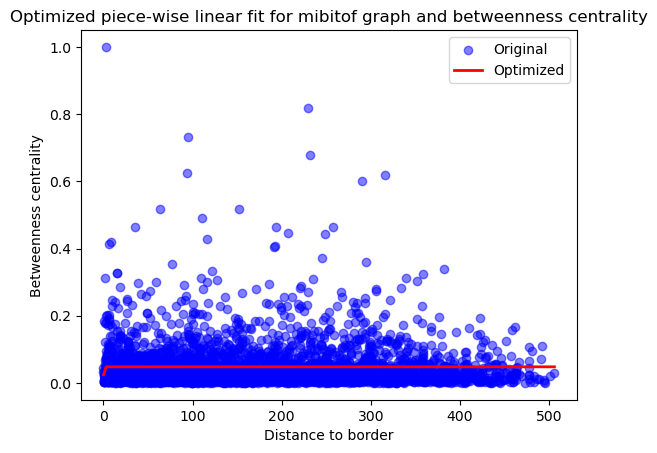

In [39]:
t = "mibitof"
n = len(real_data)
plot(d=d, C=C, m_opt=m_opt, c0_opt=c0_opt, b_opt=b_opt, measure=measure, t=t, n=n, path=f"../result_plots/{t}/{t}_{measure}_{n}.png")

NameError: name 'c_0' is not defined

In [14]:
if 0: # simulated data:
    t = "hexagonal"
    n = 400
    bounds = (0, 20)
    coordinates = generate_coordinates(n=n, bounds=bounds, type=t)
    original = create_anndata(coordinates, n_neighs=6, bounds=bounds)
    original, truncated = fully_process(adata_original=original, bounds=bounds, borders=[0])